In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

In [8]:
data_dir = 'data'
model_path = 'gesture_best.pth'
num_classes = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
print("Initializing model structure...")
model = models.mobilenet_v2(weights=None) 
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

print(f"Loading saved model weights from: {model_path}")
model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
model.eval()

Initializing model structure...
Loading saved model weights from: gesture_best.pth


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Loading test dataset...")
# Create the test dataset and dataloader
test_dataset = ImageFolder(os.path.join(data_dir, 'test'), data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
class_names = test_dataset.classes
print(f"Classes found: {class_names}")

Loading test dataset...
Classes found: ['fist', 'like', 'no_gesture', 'palm']


In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Evaluating on Test Set"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # get model predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # append batch predictions and labels to the lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# generate and print reports
print("\n" + "="*30)
print("  FINAL EVALUATION RESULTS")
print("="*30 + "\n")

# overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Test Accuracy: {accuracy:.4f} ({accuracy:.2%})\n")

# classification report 
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Evaluating on Test Set: 100%|██████████| 485/485 [45:25<00:00,  5.62s/it]



  FINAL EVALUATION RESULTS

Overall Test Accuracy: 0.9617 (96.17%)

Classification Report:
              precision    recall  f1-score   support

        fist       0.96      0.95      0.96      5000
        like       0.95      0.97      0.96      5000
  no_gesture       0.99      0.87      0.93       500
        palm       0.97      0.97      0.97      5000

    accuracy                           0.96     15500
   macro avg       0.97      0.94      0.95     15500
weighted avg       0.96      0.96      0.96     15500




Confusion Matrix:


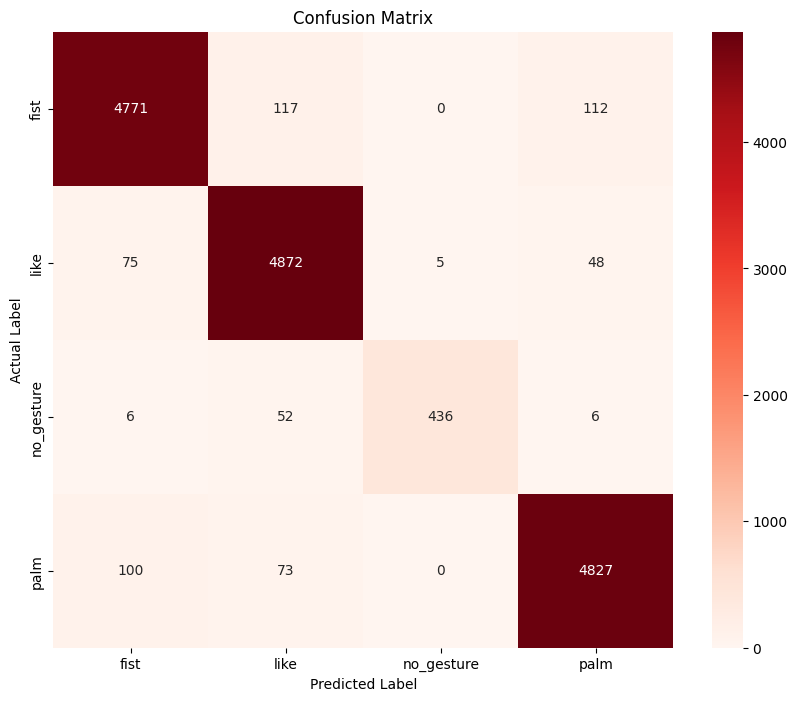

In [13]:
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()